<a href="https://colab.research.google.com/github/Madhavmurari/GAN_Model_/blob/main/C_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls /content/drive/MyDrive/datasets/floor-plan/

house_plans_details.csv  images


In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from PIL import Image

# PARAMETERS
IMG_SHAPE = (64, 64, 1)
NOISE_DIM = 100
BATCH_SIZE = 32
EPOCHS = 10000
SAVE_INTERVAL = 1000

In [10]:
# Load your DataFrame
df = pd.read_csv("/content/drive/MyDrive/datasets/floor-plan/house_plans_details.csv")  # It should have 'area', 'num_rooms', 'image'
df.head()

,Square Feet,Beds,Baths,Garages,Image Path
0,3041.0,3.0,2.5,2.0,images/0_1.jpg
1,784.0,1.0,1.0,1.0,images/0_2.jpg
2,2486.0,3.0,2.5,1.0,images/0_3.jpg
3,2220.0,3.0,2.0,1.0,images/0_4.jpg
4,3776.0,3.0,3.5,1.0,images/0_5.jpg


In [11]:
df = df.rename(columns={"Square Feet": "area", "Image Path": "image"})
df["num_rooms"] = df["Beds"] + df["Baths"] + df["Garages"]
df["num_rooms"] = df["num_rooms"].astype(int)
df = df.drop(columns=["Beds", "Baths", "Garages"])
df.head()

,area,image,num_rooms
0,3041.0,images/0_1.jpg,7
1,784.0,images/0_2.jpg,3
2,2486.0,images/0_3.jpg,6
3,2220.0,images/0_4.jpg,6
4,3776.0,images/0_5.jpg,7


In [14]:
from os import listdir
from os.path import isfile, join
mypath = "/content/drive/MyDrive/datasets/floor-plan/images"
available_imgs = [f'images/{f}' for f in listdir(mypath) if isfile(join(mypath, f))]
available_imgs[:5]

['images/1_2.jpg',
 'images/1_26.jpg',
 'images/1_30.jpg',
 'images/1_3.jpg',
 'images/1_9.jpg']

In [15]:
len(df)

2640

In [16]:
df = df[df["image"].isin(available_imgs)]

In [17]:
len(df)

1290

In [21]:
# Normalize labels
label_scaler = MinMaxScaler()
labels = label_scaler.fit_transform(df[['area', 'num_rooms']])

# Load and preprocess images
def load_image(path):
    img = Image.open(f"/content/drive/MyDrive/datasets/floor-plan/{path}").convert("L").resize((64, 64))
    return np.array(img) / 127.5 - 1.0  # Normalize to [-1, 1]

images = np.array([load_image(p) for p in df['image']])
images = np.expand_dims(images, axis=-1)

# Convert to TF datasets
dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [22]:
# Generator
def build_generator():
    noise_input = layers.Input(shape=(NOISE_DIM,))
    label_input = layers.Input(shape=(2,))
    x = layers.Concatenate()([noise_input, label_input])

    x = layers.Dense(8*8*256, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Reshape((8, 8, 256))(x)

    x = layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', use_bias=False, activation='tanh')(x)

    return tf.keras.Model([noise_input, label_input], x)

In [23]:
# Discriminator
def build_discriminator():
    img_input = layers.Input(shape=IMG_SHAPE)
    label_input = layers.Input(shape=(2,))
    label_map = layers.Dense(IMG_SHAPE[0]*IMG_SHAPE[1], use_bias=False)(label_input)
    label_map = layers.Reshape((IMG_SHAPE[0], IMG_SHAPE[1], 1))(label_map)

    x = layers.Concatenate()([img_input, label_map])

    x = layers.Conv2D(64, kernel_size=5, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)

    return tf.keras.Model([img_input, label_input], x)

In [24]:
# Loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [25]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [26]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [27]:
# Instantiate models and optimizers
generator = build_generator()
discriminator = build_discriminator()

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [34]:
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([tf.shape(labels)[0], NOISE_DIM])  # <- FIXED HERE

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [38]:
def generate_and_save_images(model, epoch):
    test_noise = tf.random.normal([1, NOISE_DIM])

    # Example: area=1200, num_rooms=3
    label = label_scaler.transform([[1200, 3]])
    label = tf.convert_to_tensor(label, dtype=tf.float32)  # <-- Convert to Tensor

    prediction = model([test_noise, label], training=False)

    img = prediction[0, :, :, 0].numpy()
    img = (img + 1) * 127.5  # Rescale to [0, 255]
    plt.imshow(img.astype(np.uint8), cmap='gray')
    plt.title(f"Epoch {epoch}")
    plt.axis("off")
    plt.show()

In [40]:
# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch, label_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, label_batch)

        if (epoch + 1) % SAVE_INTERVAL == 0:
            print(f"Epoch {epoch+1}, Gen Loss: {gen_loss.numpy():.4f}, Disc Loss: {disc_loss.numpy():.4f}")
            generate_and_save_images(generator, epoch + 1)

Epoch 1000, Gen Loss: 1.4429, Disc Loss: 1.1920


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


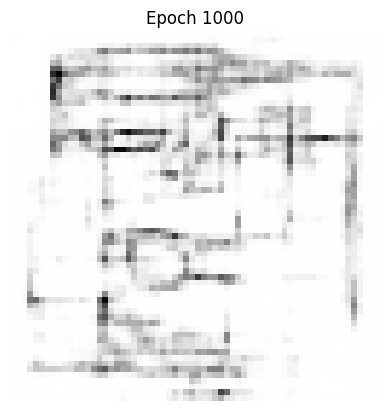

Epoch 2000, Gen Loss: 2.8334, Disc Loss: 0.9599


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


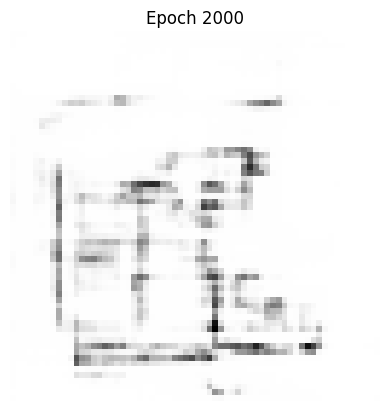

Epoch 3000, Gen Loss: 1.7958, Disc Loss: 0.6012


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


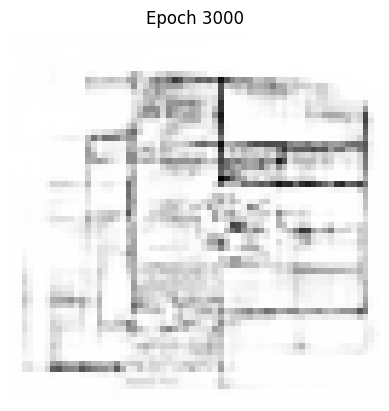

Epoch 4000, Gen Loss: 1.6056, Disc Loss: 0.6507


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


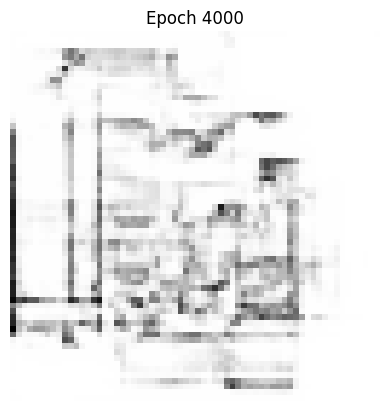

Epoch 5000, Gen Loss: 2.8914, Disc Loss: 0.4229


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


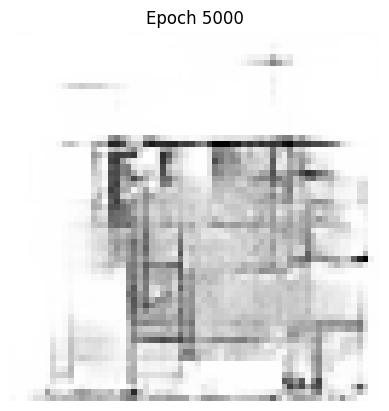

Epoch 6000, Gen Loss: 1.6549, Disc Loss: 0.4993


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


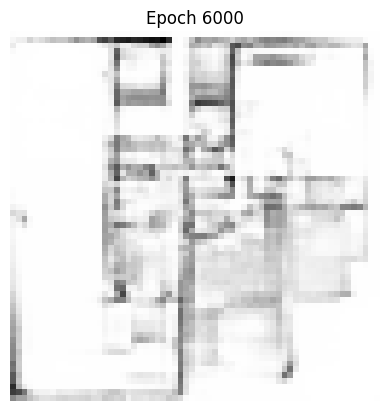

Epoch 7000, Gen Loss: 3.5981, Disc Loss: 0.3114


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


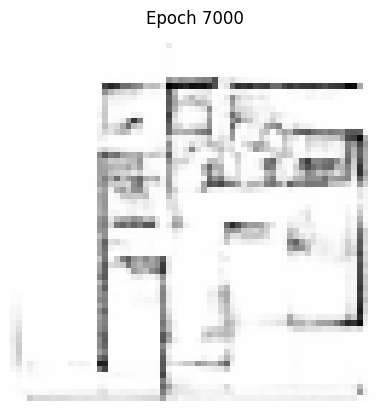

Epoch 8000, Gen Loss: 3.1084, Disc Loss: 0.2199


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


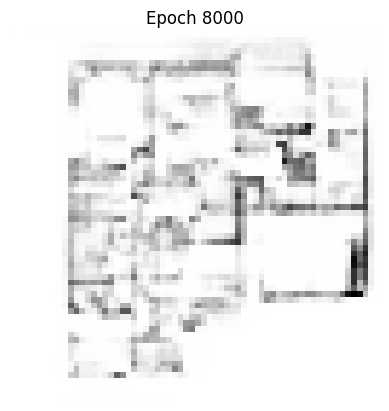

Epoch 9000, Gen Loss: 3.9499, Disc Loss: 0.4392


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


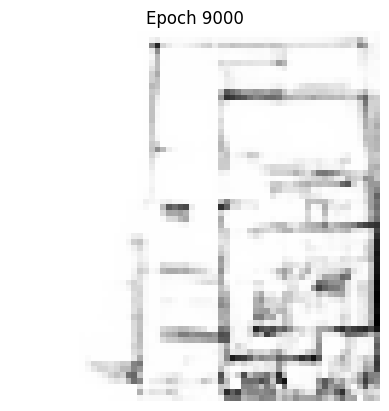

In [ ]:
# Start training
train(dataset, EPOCHS)